In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyTVDN.tmpUtils import *
from scipy.signal import lfilter, firls, decimate
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.edgecolor"] = "0.3"
#plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams['axes.labelcolor']='black'

In [3]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def SmoothEst(self):
        if self.nYmat is None:
            self._Preprocess()
        d, n = self.nYmat.shape
        acTime = n / self.paras.freq
        self.ptime = np.linspace(0, acTime, n)
        self.time = np.linspace(0, self.paras.T, n)
        divNum = 100
        if self.smoothType == "bspline":
            self.dXmat = np.zeros((d, n))
            self.Xmat = np.zeros((d, n))
            if n%divNum == 0:
                numLoop = int(n/divNum)
            else:
                numLoop = int(n/divNum) + 1
            for i in range(numLoop):
                if (i+1)*divNum <= n:
                    low = i*divNum
                    up = (i+1)*divNum
                else:
                    low = i*divNum
                    up = n
                self.dXmat[:, low:up], self.Xmat[:, low:up] = GetBsplineEst(self.nYmat[:, low:up], self.time[low:up], 
                                                                            lamb=self.paras.lamb)
        elif self.smoothType == "fourier":
            self.dXmat, self.Xmat = GetFourierEst(self.nYmat, self.time, nbasis=self.paras.nbasis)
            

### Load the dataset 

In [4]:
resDir = Path("../results")
dataDir = Path("../data/MEG-eye-unfiltering-0203")

datFil = list(dataDir.glob("*03*min.mat"))[0]
print(datFil)
gtF = list(dataDir.glob("*03_st.txt"))[0]
gtSt03 = time2pts(txt2Time(gtF), timeLims.st03)

../data/MEG-eye-unfiltering-0203/lcmv_result_R2868E_03-st_wo_filtering_min.mat


In [5]:
MEG = loadmat(datFil)
data = MEG["DK_timecourse"]

The time course is 60 seconds, so the frequency is 1200 Hz

###  Data preprocessing

In [6]:
q = 10
# originally, it is 'iir', but I dont know why it gives NAN output
# Anyway, change it to 'fir' does not affect the result a lot
# under scipy 1.3.0, works well, 
# but under scipy 1.6.2, we should use "fir" other than "iir", otherwise the decimate steps output non
dataN = decimate(data, q=q)
dataN = detrend(dataN)

In [8]:
paras = edict()
paras.Lmin = 200
paras.wh = 10
paras.MaxM = 20
paras.fct = 0.5
paras.r = 0.7
paras.freq = 120
paras.lamb = 1e-4
paras.T = 2
paras.is_detrend = False
paras.decimateRate = None
paras.kappa = 1
paras.downRate = 20

### Detection without screening

The procedure is slow, so I load saved results 

In [9]:
detRawNo = TVDNDetect1(Ymat=dataN, dataType="MEG", 
                     saveDir="../results/MEGeye-st03-ada",
                     fName="MEGEYE-st03",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEGEYE-st03',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 0.7}


In [10]:
detRawNo()

/home/huaqingj/MyResearch/TVDN/pyTVDN/TVDNclass.py:290: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)


+-------------+---------------------------------------+--------------------+------+
| Num of CPTs |             Estiamted CPTs            |        MSE         | Rank |
+-------------+---------------------------------------+--------------------+------+
|      6      | [ 593. 1531. 2783. 4106. 5893. 7000.] | 438.40057044108244 |  7   |
+-------------+---------------------------------------+--------------------+------+


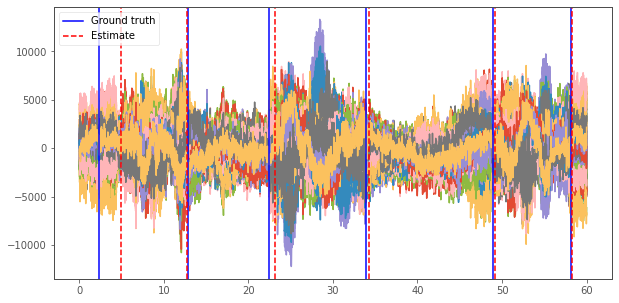

In [11]:
detRawNo.UpdateEcpts(6)
print(detRawNo)
detRawNo.PlotEcpts(GT=gtSt03.cpts)

### Test under H0: no changes 

**Obtain Amat for each time point and save it**

In [12]:
DetObj = detRawNo

In [20]:
time = DetObj.time
Xmat = DetObj.Xmat
dXmat = DetObj.dXmat
downrate = 1
fct = DetObj.paras.fct
h = bw_nrd0_R(time, fct=fct)
d, n = Xmat.shape
Amats = []
for s in tqdm(time[::downrate]):
    t_diff = time - s
    kernels = 1/np.sqrt(2*np.pi) * np.exp(-t_diff**2/2/h**2) # normal_pdf(x/h)
    kernelroot = kernels ** (1/2)
    kerdXmat = kernelroot[:, np.newaxis] * (dXmat.T) # n x d
    kerXmat = kernelroot[:, np.newaxis] * (Xmat.T) # n x d
    M = kerXmat.T.dot(kerXmat)/n
    XY = kerdXmat.T.dot(kerXmat)/n
    U, S, VT = svd(M)
    r = np.argmax(np.cumsum(S)/np.sum(S) >= 0.999) + 1 # For real data
    invM = U[:, :r].dot(np.diag(1/S[:r])).dot(VT[:r, :])
    Amat =  XY.dot(invM)
    Amats.append(Amat)
    

with open("../NeuroImgR1/Eye03_Amats.pkl", "wb") as f:
    pickle.dump(Amats, f)

100%|██████████| 7200/7200 [00:52<00:00, 136.38it/s]


In [13]:
# Recon segment-wisely with resampled data under H_0
Nrep = 100
dXmat = DetObj.dXmat
Xmat = DetObj.Xmat
Ymat = DetObj.nYmat
ecpts = DetObj.ecpts
ndXmat = DetObj.midRes.ndXmat
nXmat = DetObj.midRes.nXmat
eigVecs = DetObj.midRes.eigVecs
r = DetObj.paras.r
tStep = np.diff(DetObj.time)[0]
paras = DetObj.paras
time = DetObj.time

errsH0 = []
for jj in tqdm(range(Nrep)):
    YmatPred = ReconXmatSWHalfH0(ecpts, dXmat, Xmat, Ymat, time, rate=1, is_full=True)
    YmatPred = YmatPred.EstXmatRealOrg
    diffPred = Ymat - YmatPred
    predIdxs = np.abs(diffPred).sum(axis=0) != 0
            
    YPart = Ymat[:, predIdxs]
    YpredPart = YmatPred[:, predIdxs]
    pdiff = YPart - YpredPart
    # error under non random 
    err = np.sqrt((pdiff**2).sum(axis=0)/(YPart**2).sum(axis=0)).mean()
    errsH0.append(err)

100%|██████████| 100/100 [00:25<00:00,  3.60it/s]


In [14]:
YmatPred = ReconXmatSWHalf2(ecpts, dXmat, Xmat, Ymat, DetObj.time, rate=1, is_full=True)
YmatPred = YmatPred.EstXmatRealOrg
diffPred = Ymat - YmatPred
predIdxs = np.abs(diffPred).sum(axis=0) != 0
        
YPart = Ymat[:, predIdxs]
YpredPart = YmatPred[:, predIdxs]
pdiff = YPart - YpredPart
# error under non random 
errH12 = np.sqrt((pdiff**2).sum(axis=0)/(YPart**2).sum(axis=0)).mean()

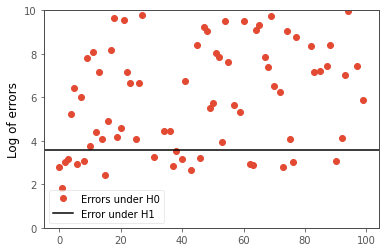

In [15]:
plt.plot(np.log(np.array(errsH0)), "o", label="Errors under H0")
plt.ylim([0, 10])
plt.ylabel("Log of errors")
plt.axhline(y=np.log(errH12), color="black", label="Error under H1")
plt.legend()

### Try different smooth method

In [16]:
paras0 = edict()
paras0.Lmin = 200
paras0.wh = 10
paras0.MaxM = 20
paras0.fct = 0.5
paras0.r = 0.7
paras0.freq = 120
paras0.lamb = 1e-2
paras0.T = 2
paras0.is_detrend = False
paras0.decimateRate = None
paras0.kappa = 1
paras0.downRate = 20

In [17]:
detRaw0 = TVDNDetect(Ymat=dataN, dataType="MEG", 
                     saveDir=None, #"MEGst02", 
                     fName="MEG1",
                     showProgress=True, 
                     MaxM=paras0.MaxM,
                     Lmin=paras0.Lmin, 
                     lamb=paras0.lamb, 
                     kappa=paras0.kappa, 
                     freq=paras0.freq,
                     r=paras0.r,
                     T=paras0.T,
                     is_detrend=paras0.is_detrend,
                     decimateRate=paras0.decimateRate, 
                     downRate=paras0.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.01,
 'nbasis': 10,
 'r': 0.7}


In [18]:
detRaw0.Screening(wh=paras0.wh)
detRaw0()

Dynamic Programming: 100%|██████████| 269/269 [00:14<00:00, 18.49it/s]


In [19]:
DetObj = detRaw0

In [20]:
# Recon segment-wisely with resampled data under H_0
Nrep = 100
dXmat = DetObj.dXmat
Xmat = DetObj.Xmat
Ymat = DetObj.nYmat
ecpts = detRawNo.ecpts
ndXmat = DetObj.midRes.ndXmat
nXmat = DetObj.midRes.nXmat
eigVecs = DetObj.midRes.eigVecs
r = DetObj.paras.r
tStep = np.diff(DetObj.time)[0]
paras = DetObj.paras
time = DetObj.time

errsH0 = []
for jj in tqdm(range(Nrep)):
    YmatPred = ReconXmatSWHalfH0(ecpts, dXmat, Xmat, Ymat, time, rate=1, is_full=True)
    YmatPred = YmatPred.EstXmatRealOrg
    diffPred = Ymat - YmatPred
    predIdxs = np.abs(diffPred).sum(axis=0) != 0
            
    YPart = Ymat[:, predIdxs]
    YpredPart = YmatPred[:, predIdxs]
    pdiff = YPart - YpredPart
    # error under non random 
    err = np.sqrt((pdiff**2).sum(axis=0)/(YPart**2).sum(axis=0)).mean()
    errsH0.append(err)

100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


In [21]:
YmatPred = ReconXmatSWHalf2(ecpts, dXmat, Xmat, Ymat, DetObj.time, rate=1, is_full=True)
YmatPred = YmatPred.EstXmatRealOrg
diffPred = Ymat - YmatPred
predIdxs = np.abs(diffPred).sum(axis=0) != 0
        
YPart = Ymat[:, predIdxs]
YpredPart = YmatPred[:, predIdxs]
pdiff = YPart - YpredPart
# error under non random 
errH12 = np.sqrt((pdiff**2).sum(axis=0)/(YPart**2).sum(axis=0)).mean()

In [22]:
pvalue = np.mean(errH12>=np.array(errsH0))

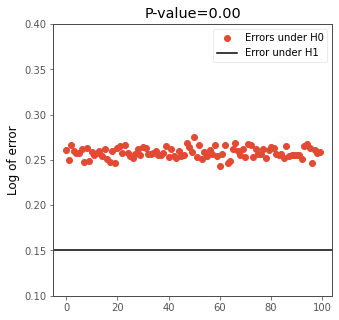

In [26]:
plt.figure(figsize=[5, 5])
plt.plot(np.log(np.array(errsH0)), "o", label="Errors under H0")
plt.ylim([0.1, 0.4])
plt.title(f"P-value={pvalue:.2f}")
plt.ylabel("Log of error")
plt.axhline(y=np.log(errH12), color="black", label="Error under H1")
plt.legend()
plt.savefig("./plots/Eye03_test_pvalue.jpg",  bbox_inches='tight')